In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import time
import sys
import matplotlib.pyplot as plt
import os

In [2]:
# Initialization
plt.rcParams["figure.figsize"]=[20,20]

In [2]:
dir_labeled = "../../research/network/dataset_network_sub_label_ip_month/"
dir_graph = "./graph/"

In [4]:
df_labeled = pd.read_pickle(dir_labeled + "201308.pkl")

In [6]:
# largest dataset
# df_labeled = pd.read_pickle(dir_labeled + "201608.pkl")

In [6]:
df_labeled.head(5)

,IP_SRC,IP_DST,RTT
0,0,1,805
1,1,2,481
2,2,3,363
3,3,4,4544
4,4,5,15819


In [7]:
df_labeled.RTT.describe()

count    2.428659e+07
mean     8.940294e+04
std      4.710001e+05
min      1.090000e+02
25%      2.816000e+03
50%      3.332600e+04
75%      1.371770e+05
max      7.818314e+07
Name: RTT, dtype: float64

### Number of nodes

In [26]:
nodes = pd. unique(df_labeled[["IP_SRC", "IP_DST"]]. values. ravel())

In [27]:
len(nodes)

678316

### Degree of nodes

In [20]:
s1 = df_labeled["IP_SRC"].value_counts()
s2 = df_labeled["IP_DST"].value_counts()
s1.add(s2, fill_value=0).sort_values(ascending=False)

612861    301544.0
355078    263364.0
355079    263227.0
308020    263162.0
308021    261476.0
            ...   
468600         1.0
240767         1.0
240768         1.0
468599         1.0
678315         1.0
Length: 678316, dtype: float64

In [5]:
s1 = df_labeled["IP_SRC"].value_counts()
s2 = df_labeled["IP_DST"].value_counts()
s1.add(s2, fill_value=0).sort_values(ascending=False)

421438    490262.0
421439    489828.0
1         461790.0
2         461786.0
3         458732.0
593876    455202.0
593877    454786.0
593875    453830.0
573830    444510.0
421440    444124.0
573831    444102.0
466527    418564.0
466528    418562.0
466529    418562.0
105965    412700.0
573832    404005.0
451922    403264.0
98284     394086.0
466532    383133.0
466533    355278.0
421437    245135.0
0         230898.0
593874    227832.0
573829    222457.0
509763    220918.0
96        214965.0
466530    210304.0
466531    209963.0
466526    209281.0
466536    208263.0
            ...   
395755         1.0
808778         1.0
808777         1.0
808776         1.0
808775         1.0
808774         1.0
808773         1.0
395779         1.0
808772         1.0
808771         1.0
808785         1.0
395729         1.0
808800         1.0
808787         1.0
808799         1.0
808798         1.0
395709         1.0
808797         1.0
395711         1.0
808796         1.0
395714         1.0
808795      

## duplicated edges

In [11]:
df_labeled.groupby(['IP_SRC', 'IP_DST']).size().nlargest(5)

IP_SRC  IP_DST
612860  612861    151847
308019  308020    132386
355077  355078    131682
355078  355079    131682
308020  308021    130776
dtype: int64

In [12]:
## degree of nodes

In [13]:
df_labeled[["IP_SRC", "IP_DST"]].drop_duplicates().groupby(['IP_SRC']).size().nlargest(5)

IP_SRC
238305    746
6         739
264841    730
3259      632
355090    632
dtype: int64

In [14]:
df_labeled[["IP_SRC", "IP_DST"]].drop_duplicates().groupby(['IP_DST']).size().nlargest(10)

IP_DST
400636    62
16800     60
238721    51
955       50
2586      50
24927     50
238703    50
238756    50
238278    49
238348    49
dtype: int64

## There could be huge standard deviation of the weights for a single edge

In [21]:
df_labeled[(df_labeled['IP_SRC'] == 0) & (df_labeled['IP_DST'] == 1)].RTT.describe()

count     90928.000000
mean       3406.705525
std       18856.641654
min         222.000000
25%         322.000000
50%         434.000000
75%         915.000000
max      544745.000000
Name: RTT, dtype: float64

In [22]:
df_01 = df_labeled[(df_labeled['IP_SRC'] == 0) & (df_labeled['IP_DST'] == 1)]

In [23]:
df_01.nlargest(3, 'RTT')

,IP_SRC,IP_DST,RTT
479538,0,1,544745
489993,0,1,438513
489977,0,1,408961


### Use mean of RTTs as weight

In [24]:
df_labeled_mean = df_labeled.groupby(['IP_SRC', 'IP_DST'], as_index=False).mean()

In [25]:
df_labeled_mean.head(5)

,IP_SRC,IP_DST,RTT
0,0,1,3406.705525
1,1,2,1717.024239
2,1,28764,414.000000
3,2,3,7759.344089
4,2,929,7164.790997


### Use median of RTTs as weight

In [21]:
df_labeled_median = df_labeled.groupby(['IP_SRC', 'IP_DST'], as_index=False).median()

In [22]:
df_labeled_median.head(5)

,IP_SRC,IP_DST,RTT
0,0,1,434.0
1,1,2,551.0
2,1,28764,414.0
3,2,3,407.0
4,2,929,506.0


# Helpers

In [23]:
# @n_sample: int
# Get a subgraph with n_sample nodes.
def G_sample(n_sample):
    G = nx.Graph()

    # # add nodes
    # for node in nodes:
    #     G.add_node(node)

    # add edges
    for index, row in df_labeled_median.iterrows():
        if index < n_sample:
            if not row['IP_SRC'] in G.nodes:
                G.add_node(row['IP_SRC'])
            if not row['IP_DST'] in G.nodes:
                G.add_node(row['IP_DST'])
            G.add_edge(row['IP_SRC'], row['IP_DST'], weight = np.float64(row['RTT']))
        else:
            break
    
    return G

In [25]:
# @G: Networkx graph
# @in_node_size: int
# Show a plot of G with node size of in_node_size nodes using spring layout which is O(n^3)
def plot_graph_spring_layout(G, in_node_size):
    plt.cla()

    pos = nx.spring_layout(G)  # positions for all nodes

    # nodes
    for node in G.nodes:
        nx.draw_networkx_nodes(G, pos,
                        nodelist=[node],
                        node_color='r',
                        node_size=in_node_size,
                        alpha=0.5)

    # edges
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.4)

    plt.axis('off')

    plt.show()

In [38]:
# @df_G: dataframe
# Get a graph using data from df_G.
def get_G(df_G):
    G = nx.Graph()

    # # add nodes
    # for node in nodes:
    #     G.add_node(node)

    # add edges
    for index, row in df_G.iterrows():
        if not row['IP_SRC'] in G.nodes:
            G.add_node(row['IP_SRC'])
        if not row['IP_DST'] in G.nodes:
            G.add_node(row['IP_DST'])
        G.add_edge(row['IP_SRC'], row['IP_DST'], weight = np.float64(row['RTT']))
    
    return G

In [39]:
# @df_G: dataframe
# Get a graph using data from df_G that modifies duplicated weights to be median.
def get_G_with_median(df_G):
    df_G_median = df_G.groupby(['IP_SRC', 'IP_DST'], as_index=False).median()
    return get_G(df_G_median)

### Show a plot with 100 nodes

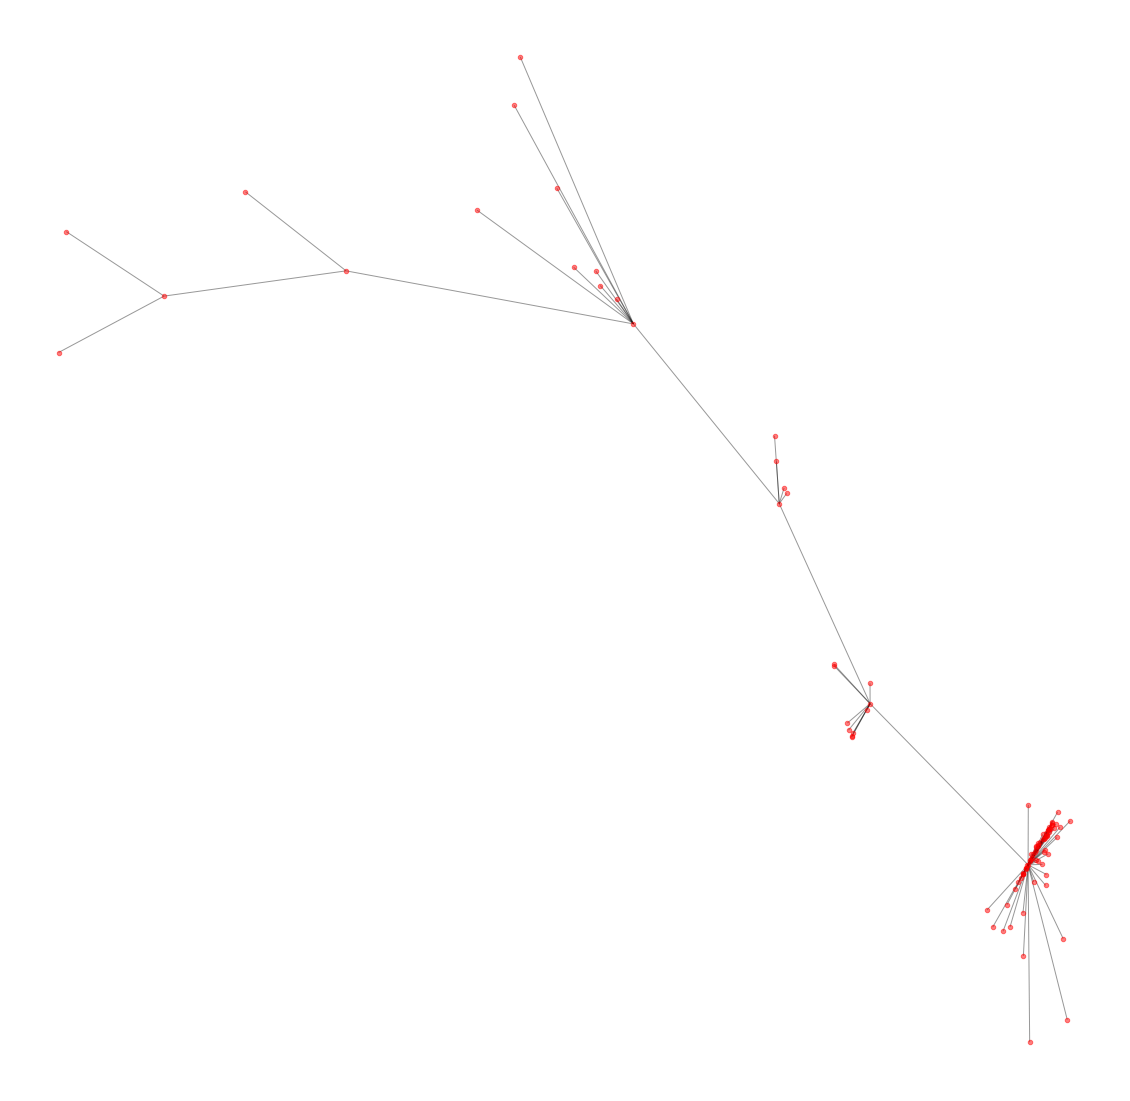

--- 0.6822085380554199 seconds ---


In [41]:
start_time = time.time()
plot_graph_spring_layout(G_sample(100), 20)
print("--- %s seconds ---" % (time.time() - start_time))

### Show a plot with 1000 nodes

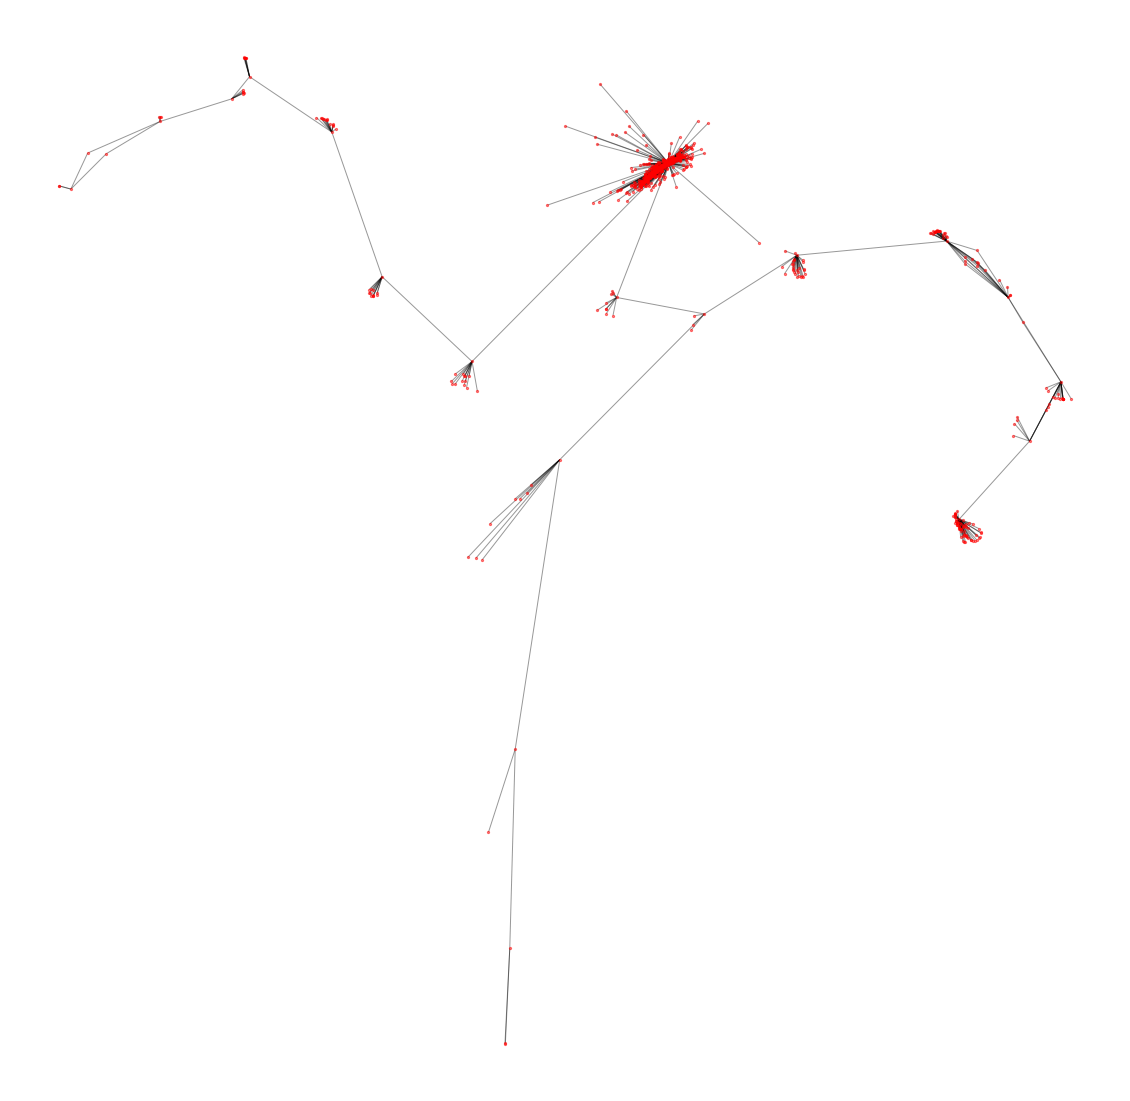

--- 10.670485258102417 seconds ---


In [42]:
start_time = time.time()
plot_graph_spring_layout(G_sample(1000), 5)
print("--- %s seconds ---" % (time.time() - start_time))

### Show a plot with 10000 nodes

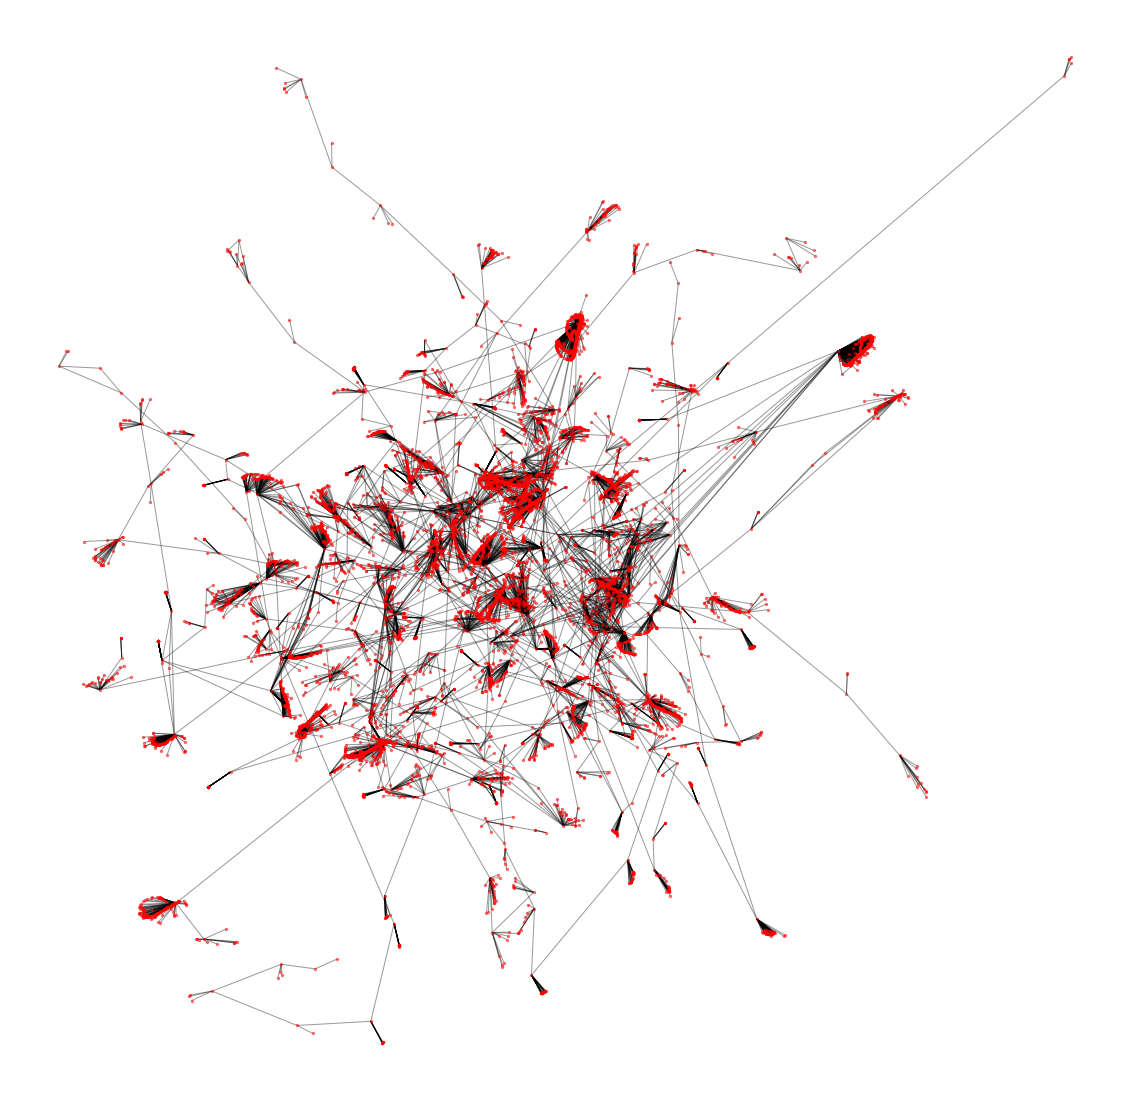

--- 353.9264953136444 seconds ---


In [59]:
start_time = time.time()
plot_graph_spring_layout(G_sample(10000), 5)
print("--- %s seconds ---" % (time.time() - start_time))

### Get attributes of a graph with 100 nodes.

In [43]:
import utils
G_tmp = G_sample(100)
utils.getHyperbolicity(G_tmp)

(0.0, 1.0, 2.0, 28764.0)
[1399.0, 1399.0, 1399.0]
hyperbolicity: 0.0


0.0

In [44]:
G_tmp.nodes

NodeView((0.0, 1.0, 2.0, 28764.0, 3.0, 929.0, 4.0, 44.0, 51.0, 96.0, 230.0, 933.0, 2052.0, 52166.0, 92812.0, 5.0, 15.0, 162.0, 4115.0, 4582.0, 6.0, 25.0, 872.0, 881.0, 1750.0, 1903.0, 4877.0, 15114.0, 56973.0, 78403.0, 7.0, 189.0, 194.0, 322.0, 403.0, 459.0, 486.0, 559.0, 582.0, 603.0, 631.0, 651.0, 788.0, 857.0, 879.0, 1010.0, 1269.0, 1272.0, 1332.0, 1340.0, 1379.0, 1389.0, 1421.0, 1986.0, 2087.0, 2111.0, 2112.0, 2168.0, 2192.0, 2222.0, 2414.0, 2424.0, 2440.0, 2741.0, 2810.0, 2874.0, 3047.0, 3177.0, 3234.0, 3362.0, 3478.0, 3630.0, 3647.0, 3857.0, 4022.0, 4069.0, 4160.0, 4205.0, 4214.0, 4437.0, 4445.0, 4465.0, 4553.0, 4675.0, 4712.0, 4775.0, 4801.0, 4910.0, 4918.0, 5040.0, 5238.0, 5269.0, 5527.0, 5568.0, 5637.0, 5836.0, 5899.0, 5941.0, 5964.0, 6050.0))

In [45]:
G_tmp.edges

EdgeView([(0.0, 1.0), (1.0, 2.0), (1.0, 28764.0), (2.0, 3.0), (2.0, 929.0), (3.0, 4.0), (3.0, 44.0), (3.0, 51.0), (3.0, 96.0), (3.0, 230.0), (3.0, 933.0), (3.0, 2052.0), (3.0, 52166.0), (3.0, 92812.0), (4.0, 5.0), (4.0, 15.0), (4.0, 162.0), (4.0, 4115.0), (4.0, 4582.0), (5.0, 6.0), (5.0, 25.0), (5.0, 872.0), (5.0, 881.0), (5.0, 1750.0), (5.0, 1903.0), (5.0, 4877.0), (5.0, 15114.0), (5.0, 56973.0), (5.0, 78403.0), (6.0, 6.0), (6.0, 7.0), (6.0, 189.0), (6.0, 194.0), (6.0, 322.0), (6.0, 403.0), (6.0, 459.0), (6.0, 486.0), (6.0, 559.0), (6.0, 582.0), (6.0, 603.0), (6.0, 631.0), (6.0, 651.0), (6.0, 788.0), (6.0, 857.0), (6.0, 879.0), (6.0, 1010.0), (6.0, 1269.0), (6.0, 1272.0), (6.0, 1332.0), (6.0, 1340.0), (6.0, 1379.0), (6.0, 1389.0), (6.0, 1421.0), (6.0, 1986.0), (6.0, 2087.0), (6.0, 2111.0), (6.0, 2112.0), (6.0, 2168.0), (6.0, 2192.0), (6.0, 2222.0), (6.0, 2414.0), (6.0, 2424.0), (6.0, 2440.0), (6.0, 2741.0), (6.0, 2810.0), (6.0, 2874.0), (6.0, 3047.0), (6.0, 3177.0), (6.0, 3234.0), (6.

In [46]:
nx.get_edge_attributes(G_tmp,'weight')

{(0.0, 1.0): 434.0,
 (1.0, 2.0): 551.0,
 (1.0, 28764.0): 414.0,
 (2.0, 3.0): 407.0,
 (2.0, 929.0): 506.0,
 (3.0, 4.0): 4527.0,
 (3.0, 44.0): 4532.0,
 (3.0, 51.0): 446.0,
 (3.0, 96.0): 4723.0,
 (3.0, 230.0): 443.0,
 (3.0, 933.0): 1118.0,
 (3.0, 2052.0): 18818.5,
 (3.0, 52166.0): 6559.0,
 (3.0, 92812.0): 412.5,
 (4.0, 5.0): 15812.0,
 (4.0, 15.0): 48800.0,
 (4.0, 162.0): 14090.0,
 (4.0, 4115.0): 9136.0,
 (4.0, 4582.0): 40385.0,
 (5.0, 6.0): 12213.0,
 (5.0, 25.0): 32312.0,
 (5.0, 872.0): 16501.0,
 (5.0, 881.0): 42147.0,
 (5.0, 1750.0): 16229.0,
 (5.0, 1903.0): 16241.5,
 (5.0, 4877.0): 16519.5,
 (5.0, 15114.0): 18142.5,
 (5.0, 56973.0): 16243.0,
 (5.0, 78403.0): 16456.0,
 (6.0, 6.0): 7016.0,
 (6.0, 7.0): 6803.0,
 (6.0, 189.0): 171850.0,
 (6.0, 194.0): 125433.0,
 (6.0, 322.0): 128067.5,
 (6.0, 403.0): 59769.5,
 (6.0, 459.0): 111360.0,
 (6.0, 486.0): 51458.0,
 (6.0, 559.0): 102293.0,
 (6.0, 582.0): 113393.0,
 (6.0, 603.0): 40412.0,
 (6.0, 631.0): 169143.0,
 (6.0, 651.0): 153553.5,
 (6.0, 788.

# Save Whole Graph Using Median

In [5]:
def toStrYearMonth(year, month):
    if month < 10:
        return str(year) + "0" + str(month)
    else:
        return str(year) + str(month)

def getNextYearMonth(year, month):
    month = month + 1
    if month > 12:
        month = 1
        year = year + 1
    return [year, month]

In [6]:
# Save graphs using dataframes for each month
# The range of data frames is from 2013-06 to 2018-12
def save_all_to_gexf():
    year = 2013
    month = 7
    
    while year < 2019:
        path_df = dir_labeled + toStrYearMonth(year, month) + ".pkl"
        if os.path.exists(path_df):
            G_whole = get_G_with_median(pd.read_pickle(path_df))

            path_graph = dir_graph + toStrYearMonth(year, month) + ".gexf"
            if os.path.exists(path_graph):
                os.remove(path_graph)
            nx.write_gexf(G_whole, path_graph)
        else:
            print(path_df + " doesn't exists")
            
        month = month + 1
        if month > 12:
            month = 1
            year = year + 1

In [42]:
len(G_whole.nodes)

678316

In [50]:
save_all_to_gexf()

../../research/network/dataset_network_sub_label_ip_month/201404.pkl doesn't exists
../../research/network/dataset_network_sub_label_ip_month/201409.pkl doesn't exists
../../research/network/dataset_network_sub_label_ip_month/201607.pkl doesn't exists
../../research/network/dataset_network_sub_label_ip_month/201709.pkl doesn't exists
../../research/network/dataset_network_sub_label_ip_month/201809.pkl doesn't exists


## Update graph

In [ ]:
"""
@G: a networkx graph
@round: round number
Deploy perturb grid with triangulation.
"""
def networkEvolutionUpdate(G, VERBOSE = False):
    if not VERBOSE:
        print('--- NEW ROUND ---')

    start_time = time.time()
    centrality = nx.edge_betweenness_centrality(G, normalized=False, weight="weight")
    if not VERBOSE:
        print("--- Get centrality takes %s seconds ---" % (time.time() - start_time))

    start_time = time.time()
    p = math.sqrt(G.number_of_nodes() ** (3/2))

    for (n1, n2) in G.edges():
        ctr = (n1, n2)
        G[n1][n2]['weight'] *= np.float64(p / (centrality[ctr] + p))

    if not VERBOSE:
        print("--- Update weights takes %s seconds ---" % (time.time() - start_time))

    return G

In [8]:
"""
@G: a networkx graph
Deploy perturb grid with triangulation.
"""
def networkEvolution(G, round, VERBOSE = False):

    if round == 0:
        plot_graph_curvature_node_racci(
            G,
            getEdgesOnSortestPath(G, T, L, 'weight', VERBOSE) + getEdgesOnSortestPath(G, B, R, 'weight', VERBOSE), VERBOSE)

    for i_round in range(round, ROUND):
        graph = nx.read_gpickle('graph_pickle/' + str(G.number_of_nodes()) + '_' + str(G.number_of_edges())
                                + '/' + str(i_round) + '.gpickle')
        graph = networkEvolutionUpdate(graph)
#         plot_graph_curvature_node_racci(
#             graph,
#             getEdgesOnSortestPath(graph, T, L, "weight", VERBOSE)
#             + getEdgesOnSortestPath(graph, B, R, "weight", VERBOSE),
#             VERBOSE)

        # TODO
        # check the similarity

        nx.write_gpickle(graph, 'graph_pickle/' + str(G.number_of_nodes()) + '_' + str(G.number_of_edges()) + '/' + str(i_round + 1) + '.gpickle')


## Example of 201307, expected 201308 and real 201308

In [3]:
year = 2013
month = 7

In [10]:
# Get G_pre and G_real
path_graph = dir_graph + toStrYearMonth(year, month) + ".gexf"
G_pre = nx.read_gexf(path_graph)
[year, month] = getNextYearMonth(year, month)
path_graph = dir_graph + toStrYearMonth(year, month) + ".gexf"
G_real = nx.read_gexf(path_graph)

In [ ]:
# Get expected 201308
#G_expect = null

In [15]:
def print_summary_of_G(G):
    print("# nodes: " + str(len(G.nodes)))
    print("# edges: " + str(len(G.edges)))

In [16]:
print_summary_of_G(G_pre)

# nodes: 678316
# edges: 1206186


In [17]:
print_summary_of_G(G_real)

# nodes: 623342
# edges: 1072151


In [33]:
G_real_sub_pre = G_real.copy()
G_real_sub_pre.remove_nodes_from(n for n in G_real if n in G_pre)
G_real_sub_pre.remove_nodes_from(list(nx.isolates(G_real_sub_pre)))
print_summary_of_G(G_real_sub_pre)

# nodes: 119132
# edges: 83936


In [34]:
G_pre_sub_real = G_pre.copy()
G_pre_sub_real.remove_nodes_from(n for n in G_pre if n in G_real)
G_pre_sub_real.remove_nodes_from(list(nx.isolates(G_pre_sub_real)))
print_summary_of_G(G_pre_sub_real)

# nodes: 142037
# edges: 107238


In [1]:
# start_time = time.time()
# plot_graph_spring_layout(G_real_sub_pre, 3)
# print("--- %s seconds ---" % (time.time() - start_time))

### Get Similarity
### Hamming distance？

In [6]:
path_graph = dir_graph + toStrYearMonth(year, month) + ".gexf"
G_pre = nx.read_gexf(path_graph)

In [2]:
def getSimilarity(G1, G2):
    
    return 0

In [ ]:
# Keep 10% high degree nodes
# Take the SP distance of node
def subset_network(G):
    

In [ ]:
# G_expected = networkEvolutionUpdate(G_pre, False)

In [11]:
len(G_pre.nodes)

678316

In [37]:
def get_nodes_by_percentage(G_in, k_begin, k_end):
    arr = sorted(G_in.degree, key=lambda x: x[1], reverse=True)
    res = [t[0] for t in arr] 
        
    res = res[int(len(arr) * k_begin): int(len(arr) * k_end)]
    return res
    
nodes_top_10_percent = get_nodes_by_percentage(G_pre, 0, 0.1)
nodes_top_1_percent = get_nodes_by_percentage(G_pre, 0, 0.01)

In [43]:
G_pre_sub = G_pre.subgraph(nodes_top_10_percent)

In [45]:
len(G_pre_sub.edges)

393393

In [46]:
G_pre_sub = G_pre.subgraph(nodes_top_1_percent)

In [48]:
len(G_pre_sub.edges)

47898

In [ ]:
# all pairs shortest path: O(n^3)

In [10]:
all_pairs_sp = dict(nx.all_pairs_dijkstra_path_length(G_pre))
print("--- Get all pair sp takes %s seconds ---" % (time.time() - start_time))

KeyboardInterrupt: 

In [ ]:
for k_in in [10, 100, 1000]:
    start_time = time.time()
    centrality = nx.edge_betweenness_centrality(G_pre, k=k_in, normalized=False, weight="weight")
    print("--- Get centrality takes %s seconds ---" % (time.time() - start_time))

--- Get centrality takes 171.59713077545166 seconds ---


In [31]:
for k_in in [10, 100, 1000]:
    start_time = time.time()
    centrality = nx.edge_betweenness_centrality(G_pre_sub, k=k_in, normalized=False, weight="weight")
    print("--- Get centrality takes %s seconds ---" % (time.time() - start_time))

--- Get centrality takes 34.24841046333313 seconds ---
--- Get centrality takes 332.4000437259674 seconds ---


KeyboardInterrupt: 

In [50]:
for k_in in [10, 100, 1000]:
    start_time = time.time()
    centrality = nx.edge_betweenness_centrality(G_pre_sub, k=k_in, normalized=False, weight="weight")
    print("--- Get centrality takes %s seconds ---" % (time.time() - start_time))

--- Get centrality takes 3.4936306476593018 seconds ---
--- Get centrality takes 22.833963871002197 seconds ---
--- Get centrality takes 225.5249092578888 seconds ---
